In [0]:
import torch
import numpy as np
import matplotlib.pyplot as plt

class GPLVM:
  def __init__(self, obs_dim, latend_dim, device="cuda" ):
    self.D = obs_dim
    self.Dz = latend_dim
    self.device = device
    self.theta0 = torch.rand(1, requires_grad=True )
    self.theta1 = torch.rand(1, requires_grad=True )
  
  def k(self, xi, xj):
    return 1.0 * torch.exp(-0.5 * 1.0 * torch.sum((xi - xj) * (xi - xj), 2)) 

  def cov(self, xi, xj, dim ):
    a = xi.view(-1,1,dim).repeat(1, len(xj), 1)
    b = xj.view(1,-1,dim).repeat(len(xi), 1, 1)
    return self.k(a,b).float()

  def learn(self, x):
    self.N = len(x)
    self.x = torch.Tensor(x)
    self.z = torch.tensor( np.random.rand(self.N, self.Dz), requires_grad=True  )

    self.x.to(self.device)
    self.z.to(self.device)
    self.theta0.to(self.device)
    self.theta1.to(self.device)

    optimizer = torch.optim.Adam( [self.theta0, self.theta1, self.z], lr=0.1)
    for i in range(1000):
      # 負の対数尤度（コスト関数）を定義
      self.alpha = torch.exp(self.theta0) + 0.001
      self.beta =  torch.exp(self.theta1) + 0.001
      self.K = self.alpha * self.cov(self.z, self.z, self.Dz) + 1/self.beta * torch.eye(self.N, self.N)
      self.K_inv = torch.inverse( self.K )
      self.x_t = torch.t( self.x )

      loss = self.D*self.N/2 * np.log(2*np.pi)
      loss += self.D/2 * torch.det(self.K)
      loss += 1/2 * torch.trace( torch.mm( torch.mm( self.K_inv, self.x ), self.x_t ) )

      # 最適化
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if i%100==0:
        print(loss)
        z = self.z.detach().numpy()
        plt.plot( z[:,0], z[:,1], "o" )
        plt.show()

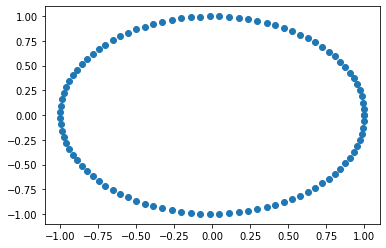

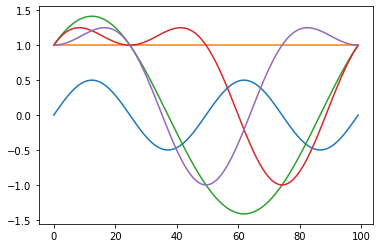

In [75]:
N = 100
D = 5

# 真の潜在変数を生成
t = np.linspace( 0, 2*np.pi, N )
z_true = np.zeros( (N, 2)  )

z_true[:,0] = np.cos(t)
z_true[:,1] = np.sin(t)

plt.plot( z_true[:,0], z_true[:,1], "o" )

# 潜在変数を適当に高次限化
x = np.zeros( (N, D) )
x[:,0] = [ z1*z2 for (z1,z2) in z_true ] 
x[:,1] = [ z1*z1+z2*z2 for (z1,z2) in z_true ] 
x[:,2] = [ z1 + z2 for (z1,z2) in z_true ] 
x[:,3] = [ z1*z1+z2 for (z1,z2) in z_true ] 
x[:,4] = [ z2*z2+z1 for (z1,z2) in z_true ] 

plt.figure()
for i in range(D):
  plt.plot( range(N), x[:,i])

tensor(9439.6260, grad_fn=<AddBackward0>)


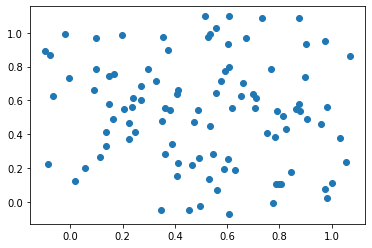

tensor(9196.1172, grad_fn=<AddBackward0>)


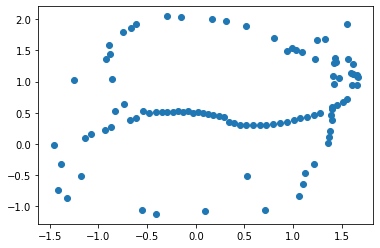

tensor(9192.7490, grad_fn=<AddBackward0>)


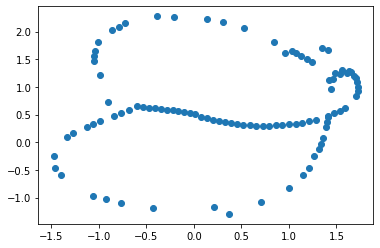

tensor(9191.5576, grad_fn=<AddBackward0>)


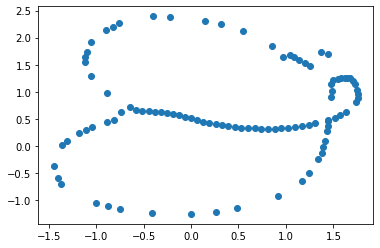

tensor(9190.9189, grad_fn=<AddBackward0>)


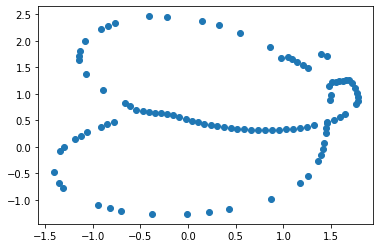

tensor(9190.5605, grad_fn=<AddBackward0>)


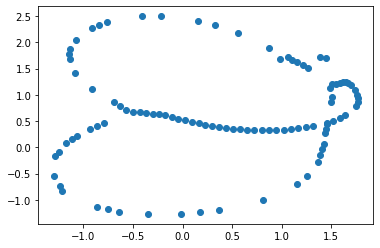

tensor(9190.3486, grad_fn=<AddBackward0>)


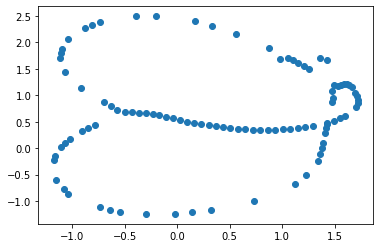

tensor(9190.1934, grad_fn=<AddBackward0>)


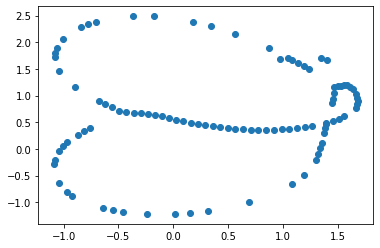

tensor(9190.0723, grad_fn=<AddBackward0>)


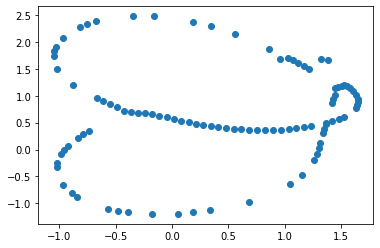

tensor(9189.9756, grad_fn=<AddBackward0>)


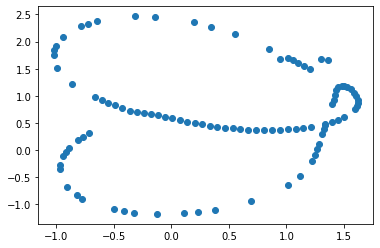

In [76]:
gp = GPLVM(N, 2)
gp.learn(x)